In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.cluster import AgglomerativeClustering
import mplfinance as mpf
from datetime import date,timedelta

# Calculate VERY simple waves
df = yf.Ticker("SQ").history(period="max") # Download Data 
df.index = pd.to_datetime(df.index)
df.drop(['Dividends','Stock Splits'], axis=1, inplace=True)


In [2]:
def ends(df, n=2): 
    """ Credited to icfly2 : https://github.com/pandas-dev/pandas/issues/18691
    Returns both head and tail of the dataframe or series. 
    Args:
        n (int): Optional number of rows to return for each head and tail
    """
    print('{} rows x {} columns'.format(np.shape(df)[0],np.shape(df)[1]))
    print(' From Date {} to Date {} '.format(df.index[0].strftime('%Y-%m-%d'),df.index[-1].strftime('%Y-%m-%d')))
    return df.head(n).append(df.tail(n))

ends(df,n=1)

1211 rows x 5 columns
 From Date 2015-11-19 to Date 2020-09-11 


,Open,High,Low,Close,Volume
Date,,,,,
2015-11-19,11.20,14.78,9.00,13.07,47466100
2020-09-11,143.91,143.91,134.26,137.45,8415600


In [3]:
# Credit to 
def generate_SR_line(df,rolling=20,start=False, end=False, duration=False, n=4, figsize = (20, 10), plot=True):
    ''' 
    Credited to Mott The Tuple @ https://stackoverflow.com/questions/8587047/support-resistance-algorithm-technical-analysis/55311893#55311893
    --------------------------------------------------------------------------------------------------------------------------
    df = DataFrame 
    n = Number of Clusters / Number of Support/Resistance Line
    Start = Start index  e.g. 0 
    End = End index e.g. 100
    Duration = # of days used in S&R line from today
    --------------------------------------------------------------------------------------------------------------------------
    '''
    
    # Choose Date Range
    if duration == False:
        df = df.iloc[start:end]
    else:
        df = df.iloc[-(duration+rolling):] # for the rolling obs waves 
    date = df.index
    
    # Reset_Index for merging 
    df.reset_index(inplace=True) 

    # Build rolling stats
    mx = df.High.rolling(rolling).max().rename('waves')
    mn = df.Low.rolling(rolling).min().rename('waves')

    mx_waves = pd.concat([mx,pd.Series(np.zeros(len(mx))+1)],axis = 1)
    mn_waves = pd.concat([mn,pd.Series(np.zeros(len(mn))+-1)],axis = 1)    

    mx_waves.drop_duplicates('waves',inplace = True)
    mn_waves.drop_duplicates('waves',inplace = True)

    W = mx_waves.append(mn_waves).sort_index()
    W = W[ W[0] != W[0].shift() ].dropna()

    # Find Support/Resistance with clustering using the rolling stats.
        # Create [x,y] array where y is always 1
    X = np.concatenate((W.waves.values.reshape(-1,1),
                        (np.zeros(len(W))+1).reshape(-1,1)), axis = 1 )
    # Clustering Algo
    cluster = AgglomerativeClustering(n_clusters=n,
              affinity='euclidean', linkage='ward')
    cluster.fit_predict(X)
    W['clusters'] = cluster.labels_

    # Get index of the max wave for each cluster
    W2 = W.loc[W.groupby('clusters')['waves'].idxmax()]
    df.index = date 
    # Plotting 
    if plot == True:
        mpf.plot(df, type='candle', style='yahoo', volume=True,
                 hlines=dict(hlines=W2.waves.to_list(), colors='g', linestyle='dashed', alpha=0.7),figsize=figsize)
        
    W2.waves.drop_duplicates(keep='first', inplace=True)
    
    return W2.reset_index().waves


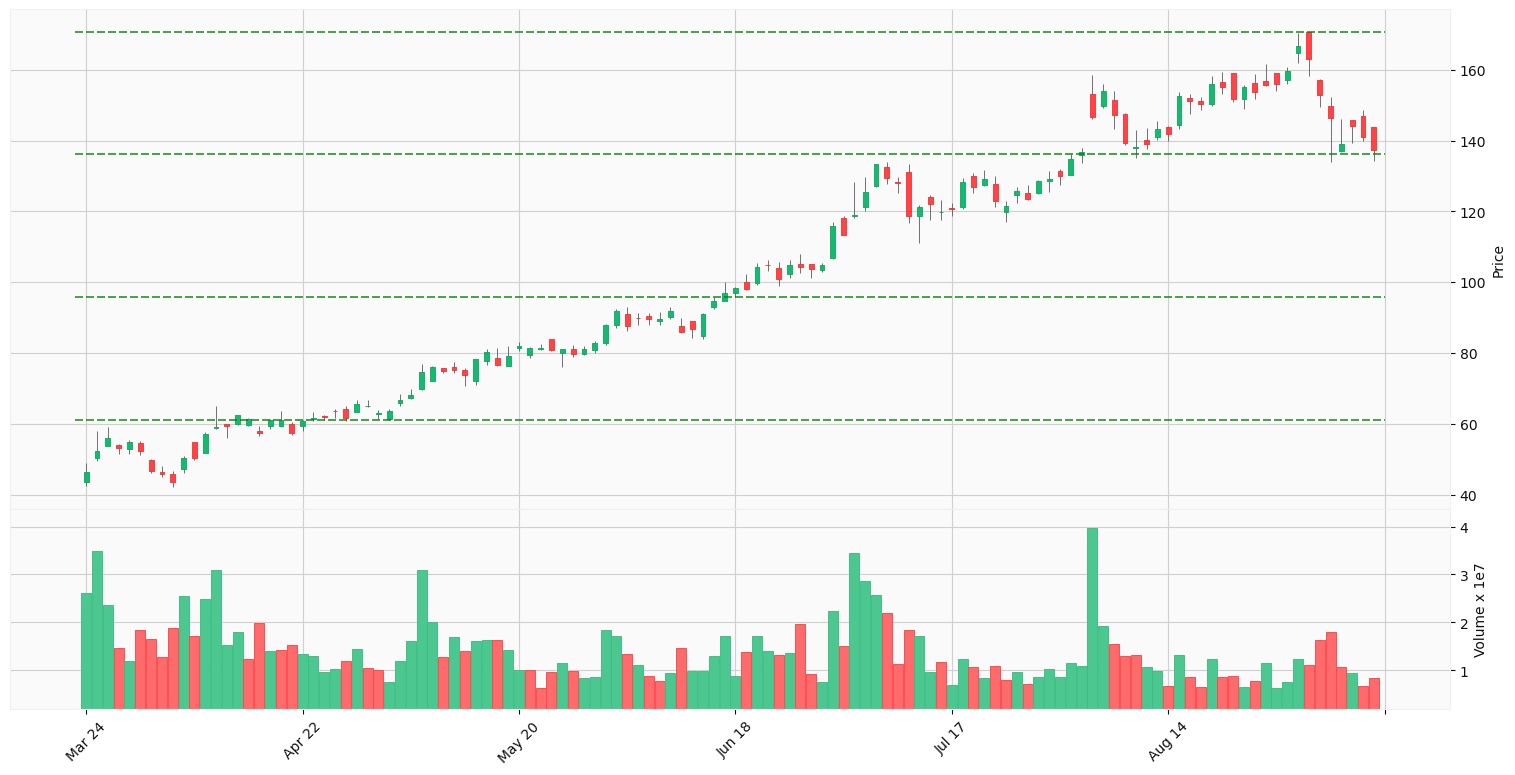

In [4]:
W2 = generate_SR_line(df, duration=100)

In [10]:
col_names = ['SR1','SR2','SR3','SR4']
start = 0 
period = 100 # roughly 1 quarter + 20 days for rolling data 

SRs = pd.DataFrame()
for i in range(0, len(df) - period):
    W = generate_SR_line(df, start = start+i, end = start+i+period, plot=False)
    SRs = SRs.append(W.iloc[0:4], ignore_index=True)
    if i == 0 or i == len(df) - period - 1:
        print('Ending Date: ' + str(df.index[start+i+period]))
SRs.columns = col_names
SRs.index = df.iloc[period:].index

Ending Date: 2016-04-15 00:00:00
Ending Date: 2020-09-11 00:00:00


In [14]:
dfs = pd.concat([df, SRs], axis=1).dropna()
ends(dfs)

1111 rows x 9 columns
 From Date 2016-04-15 to Date 2020-09-11 


,Open,High,Low,Close,Volume,SR1,SR2,SR3,SR4
Date,,,,,,,,,
2016-04-15,14.85,14.87,14.18,14.33,2405100,15.91,10.90,9.63,11.80
2016-04-18,14.20,14.71,14.13,14.51,1384700,12.90,10.90,10.80,15.13
2020-09-10,147.02,148.54,139.82,141.07,6711500,136.13,95.87,170.61,71.07
2020-09-11,143.91,143.91,134.26,137.45,8415600,136.13,95.87,170.61,71.07
